# **The problem**

Anomaly detection is a common problem for the most of companies in the world. Its detection must be accurate to not harm any legitimate costumer. The goal here is to analyze a dataset which contains information about credit card usage.

The dataset analyzed here came from several JSON files that contains more than 4.000.000 credit card transactions from 100.000 users. These JSON files were converted into a dataframe which some new features was created, then we transformed that dataframe into a new one with information for each user, like their credit card profile usage, their transaction velocity and some flags, such as suspicious flags based on outliers for some features distribuition.

With the profile of each user, the main goal of this project is not predict whether an user going to fraud or not, but try to learn the their normal behaviour and check for some anomalies.

The project consists on the following steps:


*   Basic view of dataset
*   Exploratory Data Analysis
*   Data Preprocessing 
*   One Class Classification
*   Results

## Understanding the dataset

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.3f}'.format

In [56]:
df = pd.read_csv("users_profile.csv")

In [57]:
df.head()

,user_id,total_transactions,quartilebased_suspicious_flag,Discover,JCB_15,JCB_16,Maestro,Mastercard,american_express,diners_club,visa_13,visa_16,visa_19,overall_velocity,avg_hourly_velocity,ovrvelocity_suspicious_flag,hourvelocity_suspicious_flag
0,0,21,0,0.000,1.000,5.000,0.000,0.000,5.000,1.000,2.000,5.000,2.000,21.000,3.833,1,0
1,1,51,0,4.000,2.000,12.000,4.000,5.000,3.000,4.000,4.000,9.000,4.000,7.286,3.683,0,0
2,2,63,0,4.000,7.000,11.000,4.000,7.000,6.000,3.000,5.000,13.000,3.000,7.875,4.600,0,0
3,3,17,0,1.000,1.000,7.000,1.000,1.000,1.000,1.000,2.000,1.000,1.000,2.429,1.500,0,0
4,4,65,0,4.000,4.000,13.000,8.000,3.000,8.000,7.000,4.000,9.000,5.000,8.125,5.400,0,0


The data set has 17 columns, which are:


*   user_id: unique identification for each user
*   total_transactions: total transactions made by the user
*   quartilebased_suspicious_flag: flag that indicates users with more transaction than 3rd quartile + 1,5IQR of total_transaction
*   Discover: number of times used credit card card from Discover provider
*   JCB_15: number of times used credit card card from JCB 15 digits provider
*   JCB_16: number of times used credit card card from JCB 16 digits provider
*   Maestro: number of times used credit card card from Maestro provider
*   Mastercard: number of times used credit card card from Mastercard provider
*   american_express: number of times used credit card card from American Express provider
*   diners_club: number of times used credit card card from Diners Club provider
*   visa_13: number of times used credit card card from Visa 13 digits provider
*   visa_16: number of times used credit card card from Visa 16 digits provider
*   visa_19: number of times used credit card card from Visa 19 digits provider
*   overall_velocity: total transactions divided by number of days the user made transactions
*   avg_hourly_velocity: average per day of transaction made per hour
*   ovrvelocity_suspicious_flag: flag that indicates users with velocity greater than 3rd quartile + 1,5IQR of overall_velocity
*   hourvelocity_suspicious_flag: flag that indicates users with velocity greater than 3rd quartile + 1,5IQR of avg_hourly_velocity


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   user_id                        100000 non-null  int64  
 1   total_transactions             100000 non-null  int64  
 2   quartilebased_suspicious_flag  100000 non-null  int64  
 3   Discover                       100000 non-null  float64
 4   JCB_15                         100000 non-null  float64
 5   JCB_16                         100000 non-null  float64
 6   Maestro                        100000 non-null  float64
 7   Mastercard                     100000 non-null  float64
 8   american_express               100000 non-null  float64
 9   diners_club                    100000 non-null  float64
 10  visa_13                        100000 non-null  float64
 11  visa_16                        100000 non-null  float64
 12  visa_19                        

## 1. Exploratory Data Analysis

In this section, we are going to analyse how our data is organized and try to extract some insights from it. The dataset consists on, for each user, flags, velocity and how many times the user have used a credit card. These variables are essentially numerical, with exception of the flags, which are encoded as 0 and 1, with 1 meaning suspicious activity.

In [59]:
df.describe()

,user_id,total_transactions,quartilebased_suspicious_flag,Discover,JCB_15,JCB_16,Maestro,Mastercard,american_express,diners_club,visa_13,visa_16,visa_19,overall_velocity,avg_hourly_velocity,ovrvelocity_suspicious_flag,hourvelocity_suspicious_flag
count,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000
mean,50000.218,41.000,0.011,3.415,3.413,6.835,3.413,3.424,3.413,3.418,3.412,6.836,3.420,6.473,3.184,0.062,0.022
std,28868.008,17.636,0.106,2.306,2.304,3.792,2.294,2.306,2.305,2.300,2.312,3.800,2.309,3.676,1.147,0.241,0.146
min,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000
25%,24999.750,28.000,0.000,2.000,2.000,4.000,2.000,2.000,2.000,2.000,2.000,4.000,2.000,4.375,2.333,0.000,0.000
50%,50000.500,39.000,0.000,3.000,3.000,6.000,3.000,3.000,3.000,3.000,3.000,6.000,3.000,5.667,2.980,0.000,0.000
75%,75000.250,52.000,0.000,5.000,5.000,9.000,5.000,5.000,5.000,5.000,5.000,9.000,5.000,7.286,3.817,0.000,0.000
max,100000.000,145.000,1.000,20.000,20.000,31.000,20.000,21.000,20.000,19.000,20.000,28.000,21.000,43.000,10.992,1.000,1.000


In [60]:
print(f"Users made {df['total_transactions'].sum()} transactions")

Users made 4100000 transactions


In [61]:
credit_cards = df.iloc[:,3:13].copy()
credit_cards.head()

,Discover,JCB_15,JCB_16,Maestro,Mastercard,american_express,diners_club,visa_13,visa_16,visa_19
0,0.000,1.000,5.000,0.000,0.000,5.000,1.000,2.000,5.000,2.000
1,4.000,2.000,12.000,4.000,5.000,3.000,4.000,4.000,9.000,4.000
2,4.000,7.000,11.000,4.000,7.000,6.000,3.000,5.000,13.000,3.000
3,1.000,1.000,7.000,1.000,1.000,1.000,1.000,2.000,1.000,1.000
4,4.000,4.000,13.000,8.000,3.000,8.000,7.000,4.000,9.000,5.000


In [62]:
print('The top 2 most used credit card are:')
print(credit_cards.sum().sort_values(ascending=False)[0:2].index[0]+': ',
      int(credit_cards.sum().sort_values(ascending=False)[0:2].values[0]))
print(credit_cards.sum().sort_values(ascending=False)[0:2].index[1]+': ',
      int(credit_cards.sum().sort_values(ascending=False)[0:2].values[1]))

The top 2 most used credit card are:
visa_16:  683626
JCB_16:  683521


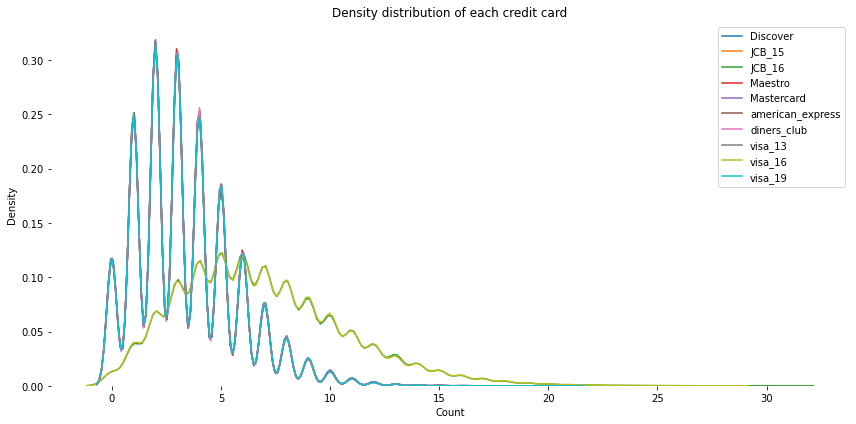

In [63]:
ax, fig = plt.subplots(figsize=(12,6))

for card in credit_cards.columns:

  ax = sns.kdeplot(credit_cards[card], label=card)

plt.legend()
ax.set_title('Density distribution of each credit card')
ax.set_xlabel('Count')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_yaxis().set_visible(True)
ax.get_xaxis().set_visible(True)
plt.tight_layout();

The above plot shows that there are only 2 distributions of credit card usage. JCB_16 and VISA_16 have the same distribution and all other credit card follow other, but same, distribution. This occurs because the dataset was generated 

In [64]:
dfm = credit_cards.melt(var_name='columns')
dfm

,columns,value
0,Discover,0.000
1,Discover,4.000
2,Discover,4.000
3,Discover,1.000
4,Discover,4.000
...,...,...
999995,visa_19,6.000
999996,visa_19,7.000
999997,visa_19,6.000
999998,visa_19,4.000


C:\Users\raffa\Anaconda3\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


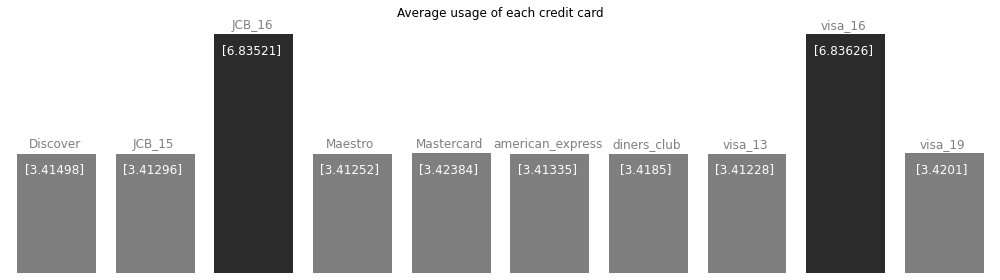

In [65]:
data = dfm.groupby('columns').mean()
clrs = ['#7F7F7F' if (x < 4) else '#2B2B2B' for x in data.values]

ax, fig = plt.subplots(figsize=(14,4))
ax = sns.barplot(x=data.index, y=data.value, palette=clrs)

for p, label in zip(ax.patches, dfm.groupby('columns').mean().values):
    ax.annotate(label, (p.get_x()+0.375, p.get_height()-0.25),ha='center',
            va='top',
            fontsize=12,
            color='white')

for p, label in zip(ax.patches, dfm.groupby('columns').mean().index):
    ax.annotate(label, (p.get_x()+0.38, p.get_height()+0.1),ha='center',
            va='bottom',
            fontsize=12,
            color='#7F7F7F')  

ax.set_title('Average usage of each credit card')
ax.set_xlabel('')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.tight_layout();

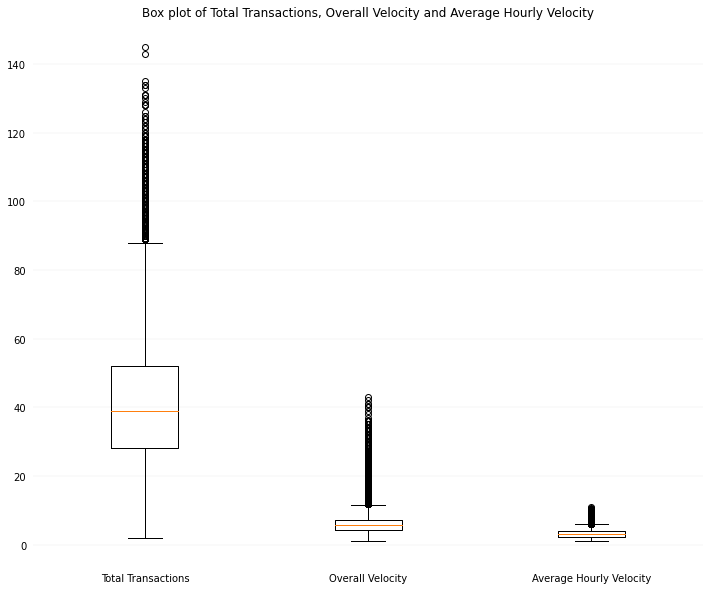

In [66]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')

ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.3)

ax.set_title('Box plot of Total Transactions, Overall Velocity and Average Hourly Velocity')

dataset = [df['total_transactions'],
           df['overall_velocity'], 
           df['avg_hourly_velocity']]

labels = ['Total Transactions', 'Overall Velocity', 'Average Hourly Velocity']

ax.boxplot(dataset, labels=labels)
plt.show()

The outliers shown in the above box plots indicates possible anomalies, which are marked on the dataset as flags.

In [67]:
print(f"Users made in average {int(df.total_transactions.mean())} transactions ")
print(f"Users made in average {int(df.overall_velocity.mean())} transactions per day")
print(f"Users made in average {int(df.avg_hourly_velocity.mean())} transactions per hour")

Users made in average 41 transactions 
Users made in average 6 transactions per day
Users made in average 3 transactions per hour


In [68]:
print('{}% users made more transactions than usual'.format(
    df['quartilebased_suspicious_flag'].mean()*100))

print('{}% users made transactions faster than usual'.format(
    df['ovrvelocity_suspicious_flag'].mean()*100))

print('{}% users made transactions per hour faster than usual'.format(
    df['hourvelocity_suspicious_flag'].mean()*100))

1.147% users made more transactions than usual
6.184% users made transactions faster than usual
2.177% users made transactions per hour faster than usual


In [69]:
susp_transaction_user = df[df['quartilebased_suspicious_flag'] == 1].copy()
susp_ovrvelocity_user = df[df['ovrvelocity_suspicious_flag'] == 1].copy()
susp_hourlyvelocity_user = df[df['hourvelocity_suspicious_flag'] == 1].copy()

credit_cards_all = df.iloc[:,3:13].copy()
credit_cards_trans = susp_transaction_user.iloc[:,3:13].copy()
credit_cards_ovrvel = susp_ovrvelocity_user.iloc[:,3:13].copy()
credit_cards_hourvel = susp_hourlyvelocity_user.iloc[:,3:13].copy()

df_all = credit_cards_all.melt(var_name='columns')
df_trans = credit_cards_trans.melt(var_name='columns')
df_ovrvel = credit_cards_ovrvel.melt(var_name='columns')
df_hourvel = credit_cards_hourvel.melt(var_name='columns')

In the next plot, we can see that users marked with some flag have different usage profile for each credit card.

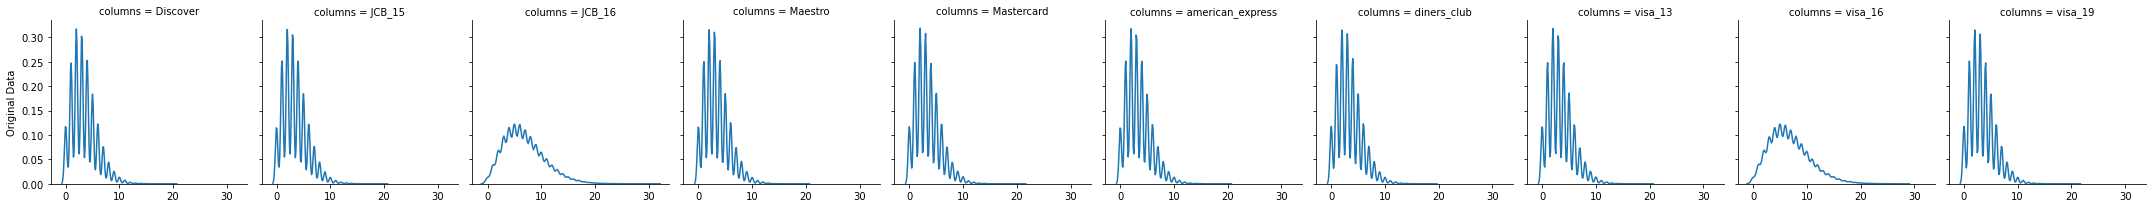

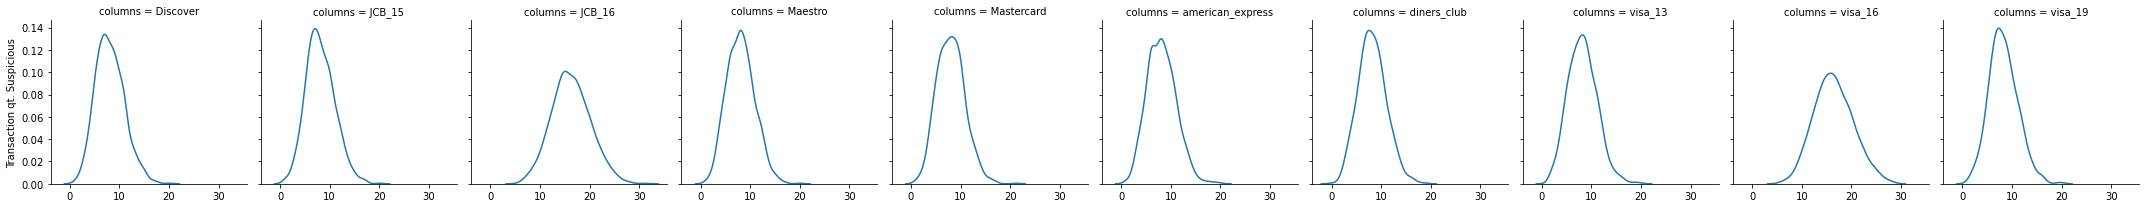

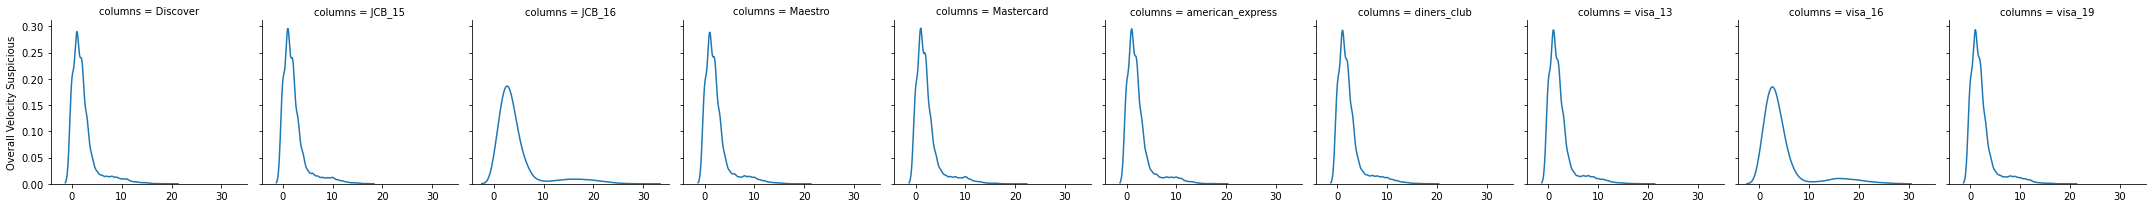

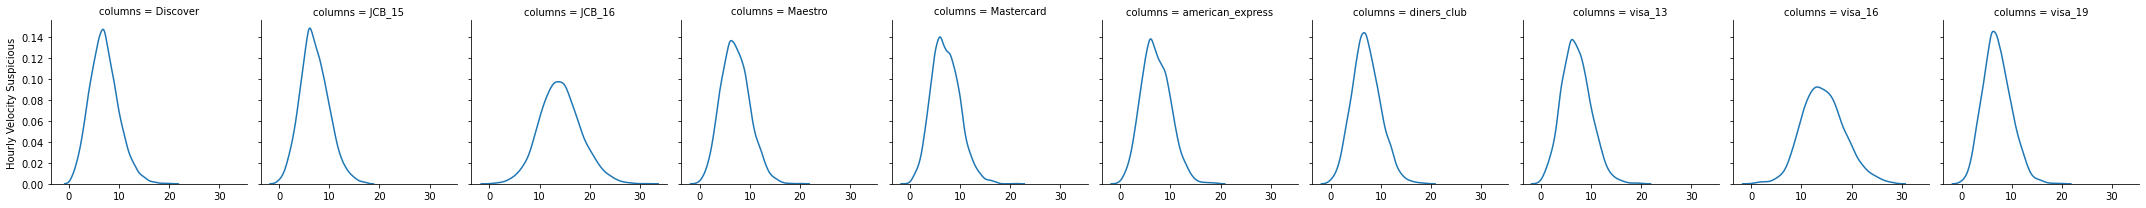

In [70]:
g = sns.FacetGrid(df_all, col='columns')
h = sns.FacetGrid(df_trans, col='columns')
i = sns.FacetGrid(df_ovrvel, col='columns')
j = sns.FacetGrid(df_hourvel, col='columns')

g = (g.map(sns.kdeplot, 'value'))
g.set_axis_labels("", "Original Data")
g.tight_layout()

h = (h.map(sns.kdeplot, 'value'))
h.set_axis_labels("", "Transaction qt. Suspicious")
h.tight_layout()

i = (i.map(sns.kdeplot, 'value'))
i.set_axis_labels("", "Overall Velocity Suspicious")
i.tight_layout()

j = (j.map(sns.kdeplot, 'value'))
j.set_axis_labels("", "Hourly Velocity Suspicious")               
j.tight_layout();

## 2. Unsupervised Learning for Anomaly Detection

In this project, we have an unsupervised learning task, since we have no label that indicates anomaly behaviour. One good option for this problem is implement One Class Support Vector Machine to classify users with anomalous profile. 

The One Class SVM is a novelty detector, that means the One Class SVM is first trained to learn the normality, then the algorithm can indentify a anomaly.

In [25]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

In [26]:
svm = OneClassSVM(kernel='rbf',nu=0.001, gamma='scale') 
scaler = StandardScaler()

In [27]:
#drop the flags to comparison purposes
train_df = df.drop(['user_id', 
                    'quartilebased_suspicious_flag', 
                    'ovrvelocity_suspicious_flag', 
                    'hourvelocity_suspicious_flag'], axis=1).copy()

#Getting only the users who have no suspicious flag
normality_index = df.loc[(df['quartilebased_suspicious_flag'] == 0) & 
                         (df['ovrvelocity_suspicious_flag'] == 0) & 
                         (df['hourvelocity_suspicious_flag'] == 0)].index

#Dataframe with only normal users to train our model
train_df_normal = train_df.iloc[normality_index]
train_df_normal.head()

,total_transactions,Discover,JCB_15,JCB_16,Maestro,Mastercard,american_express,diners_club,visa_13,visa_16,visa_19,overall_velocity,avg_hourly_velocity
1,51,4.0,2.0,12.0,4.0,5.0,3.0,4.0,4.0,9.0,4.0,7.285714,3.683333
2,63,4.0,7.0,11.0,4.0,7.0,6.0,3.0,5.0,13.0,3.0,7.875000,4.600000
3,17,1.0,1.0,7.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.428571,1.500000
4,65,4.0,4.0,13.0,8.0,3.0,8.0,7.0,4.0,9.0,5.0,8.125000,5.400000
6,56,5.0,4.0,7.0,3.0,10.0,5.0,2.0,4.0,11.0,5.0,8.000000,4.675000


In [28]:
train_df_normal_scaled = scaler.fit_transform(train_df_normal)
svm.fit(train_df_normal_scaled)

OneClassSVM(nu=0.001)

In [29]:
train_df_scaled = scaler.transform(train_df)
results = svm.predict(train_df_scaled)

In [30]:
results

array([-1,  1,  1, ...,  1,  1,  1], dtype=int64)

In [31]:
anomaly_df = df.copy()
anomaly_df['anomaly'] = results

In [32]:
#Converting the result to 0/1 pattern
anomaly_df['anomaly'] = np.where(anomaly_df['anomaly'] == -1, 1, 0)

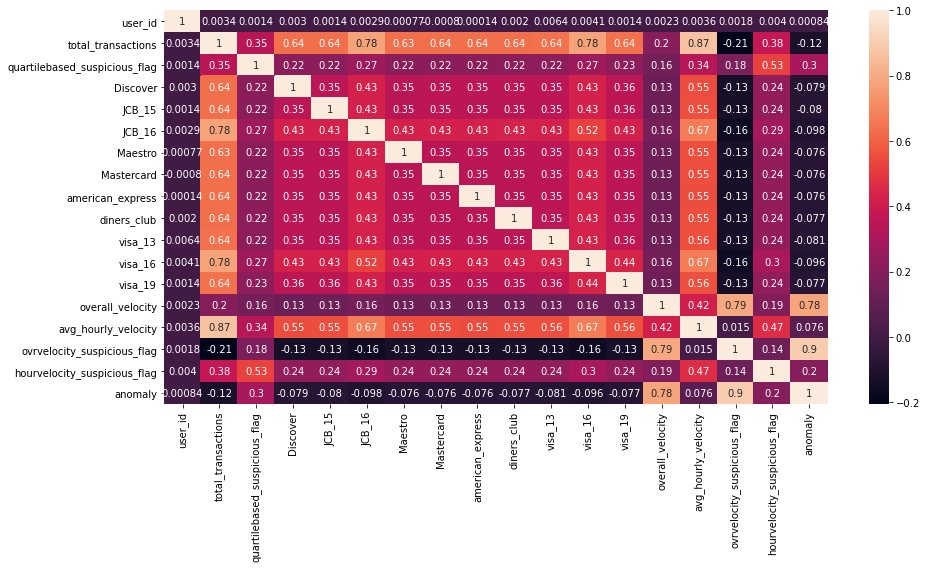

In [71]:
ax, fig = plt.subplots(figsize=(14,8))
ax = sns.heatmap(anomaly_df.corr(), annot=True)
plt.tight_layout()

From the above plot, we can see that our model can find outliers from the given dataset. The heatmap shows positive correlation between the models' predictions and flags variables, which are not provided to the training dataframe, specially for overall velocity suspicious flag variable, that have high correlation value (0.9).

Just for visualization purposes, lets use ovrvelocity_suspicious_flag as target variable to calculate some basic Machine Learning scores... Here, we are interested only in Recall, Precision and F1 scores, since we have a highly unbalanced dataset and, naturally, the model have good accuracy score.

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

Precision is a metric that shows how many of actual positive class was correctly predicted: $Precision = \frac{T_p}{T_p + F_p}$;

Recall shows how many of predict as positive class was in fact positive: $Recall = \frac{T_p}{T_p + F_N}$;

F1-Score is the harmonic mean between Precision and Recall: $\frac{2\times Precision\times Recall}{Precision + Recall}$.

In [35]:
print("Recall Score: {}\n".format(recall_score(anomaly_df['ovrvelocity_suspicious_flag'],
                                             anomaly_df['anomaly'])))
print("Precision Score: {}\n".format(precision_score(anomaly_df['ovrvelocity_suspicious_flag'],
                                             anomaly_df['anomaly'])))
print("F1 Score: {}\n".format(f1_score(anomaly_df['ovrvelocity_suspicious_flag'],
                                             anomaly_df['anomaly'])))

print('Confusion Matrix:\n', confusion_matrix(anomaly_df['ovrvelocity_suspicious_flag'], anomaly_df['anomaly']))

Recall Score: 0.9062095730918499

Precision Score: 0.9076773566569485

F1 Score: 0.9069428710147273

Confusion Matrix:
 [[93246   570]
 [  580  5604]]


Although the model has shown good perfomance, we must know that anomaly flag doesn't indicate fraud, but shows users with behaviour different than the normal. In this regard, we must use the suspicious flags to prioritize some users for further analysis.

The below dataframe show us the users who has high priority, since they have all flags

In [36]:
anomaly_df.loc[(anomaly_df['anomaly'] == 1) & 
       (anomaly_df['quartilebased_suspicious_flag'] == 1) &
       (anomaly_df['ovrvelocity_suspicious_flag'] == 1) &
       (anomaly_df['hourvelocity_suspicious_flag'] == 1)]

,user_id,total_transactions,quartilebased_suspicious_flag,Discover,JCB_15,JCB_16,Maestro,Mastercard,american_express,diners_club,visa_13,visa_16,visa_19,overall_velocity,avg_hourly_velocity,ovrvelocity_suspicious_flag,hourvelocity_suspicious_flag,anomaly
58,58,106,1,10.0,13.0,14.0,7.0,9.0,6.0,8.0,10.0,20.0,9.0,13.250000,8.760000,1,1,1
125,125,107,1,12.0,12.0,17.0,4.0,3.0,10.0,10.0,7.0,25.0,7.0,13.375000,7.900000,1,1,1
194,194,107,1,9.0,6.0,13.0,13.0,14.0,9.0,8.0,11.0,11.0,13.0,13.375000,8.033333,1,1,1
830,830,91,1,8.0,4.0,13.0,8.0,8.0,9.0,11.0,9.0,15.0,6.0,13.000000,8.133333,1,1,1
1283,1283,109,1,8.0,11.0,24.0,7.0,8.0,4.0,7.0,12.0,24.0,4.0,13.625000,8.040000,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98858,98859,130,1,9.0,6.0,25.0,13.0,10.0,8.0,14.0,14.0,16.0,15.0,16.250000,9.106667,1,1,1
98979,98980,110,1,7.0,11.0,22.0,10.0,15.0,4.0,15.0,8.0,9.0,9.0,13.750000,7.766667,1,1,1
99028,99029,93,1,6.0,14.0,13.0,11.0,13.0,6.0,3.0,4.0,12.0,11.0,13.285714,8.000000,1,1,1
99154,99155,101,1,11.0,8.0,16.0,9.0,8.0,10.0,7.0,7.0,18.0,7.0,12.625000,7.260000,1,1,1


## 3. Results

This project was performed by converting many JSON files of credit card transaction log for a certain company. These JSON files was transformed into a pandas dataframe, which have 4100000 transactions of 100000 costumers. From these transactions, several features was created, then grouped for each user, resulting in a new dataset. After that, in this new dataset, we looked for detect anomalies from each user characteristics, such as velocity and number of transactions. The chosen algorithm to perform the anomaly detection was One Class SVM, that learns whats is normal to classify anomalies.

The model used to indetify anomalies performed as expected, showing positive correlações between their result and suspicious flags. Although the correlations wasn't that strong, with exception of overall_velocity variable, the model can indicates wheter the user shows anomalous behaviour or not. Thus, the model has potential to be optimized and scaled to be used in production.

## 4. Recommendations

Although the model have succeded to performs as expected, the results are bellow than the necessary to be effective in real world. This occurs because the given dataset has, for the most part, identifiers and dates, not being possible extract more information for each user. Therefore, it is recommended extract more information for each transaction, like ammount spent, geographic location, e-mail domain, etc.

## 5. Next Steps

The work done here is, essentially, research and, because of that, is not ready to be in production. The next step, then, would be split the users in train, validation and test set to generate a credit card profile usage from the pipeline described as in the other notebook. The model would be cross-validated using the train and validation dataset, then the test set, acting as never seen data, would go through the pipeline and have its predictions made, then being able to be in production.